# Initialize all imports

In [1]:
import os
import conda_installer
import pandas as pd
import tensorflow as tf
import numpy as np
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


2025-05-02 12:15:52.230066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 12:15:52.485954: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('Datasets/T_data.csv')

In [3]:
df.head()

,Unnamed: 0,Id,TS_comp,TS_host,TS_ligand,exp
0,0,gilson_cb7--guest1,219.726160,170.780918,32.569296,-0.9
1,1,gilson_cb7--guest2,243.211795,170.780918,54.026506,-0.4
2,2,gilson_cb7--guest3,228.890715,170.780918,41.655571,-0.1
3,3,gilson_cb7--guest4,203.927320,170.780918,19.589363,0.6
4,4,gilson_cb7--guest5,266.219403,170.780918,80.367673,0.0


In [4]:

len(PDBs)

103

In [5]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [6]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

## VM2 Entropy with Loss

In [7]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [8]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(82, 21, 82, 21)

In [10]:
X_train[1].shape

(100, 41)

# Helper Functions

In [11]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)

<module 'models.layers_update_mobley' from '/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/models/layers_update_mobley.py'>

In [12]:
class PGGCNModel_Hybrid(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([-.3, -1, 1, 1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        self.all_layer_1_weights = []

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
        
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)    

class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dS_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    host = tf.gather(physics_info, [1], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [2], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [0], axis=1)  # Complex energy terms


    # Calculate TΔS based on physics: ΔS = ΔScomplex - (ΔShost + ΔSguest)
    dS_physics = -tf.reduce_sum(complex_, axis=1, keepdims=True) + tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True)
    phy_loss = K.sqrt(K.mean(K.square(dS_pred - dS_physics)))

    return phy_loss



def combined_loss(physics_hyperparam=0.0003):
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:4]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Combine losses with weights
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 
        
        return total_loss
    
    return loss_function

2025-05-02 12:16:03.765383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-02 12:16:03.765418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-05-02 12:16:03.766114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------- Hyperparameter combinations ------------
Epoch : 400;  physics_weight: 0.005;
Epoch 1/400
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inside call
1/1 [==============================] - 77s 77s/step - loss: 13.2129
Epoch 2/400
1/1 [==============================] - 1s 1s/step - loss: 11.0786
Epoch 3/400
1/1 [==============================] - 1s 773ms/step - loss: 9.0041
Epoch 4/400
1/1 [==============================] - 1s 1s/step - loss: 7.0379
Epoch 5/400
1/1 [==============================] - 1s 1s/step - loss: 5.3002
Epoch 6/400
1/1 [==============================] - 1s 1s/step - loss: 4.0887
Epoch 7/400
1/1 [==============================] - 1s 1s/step - loss: 3.8678
Epoch 8/400
1/1 [==============================] - 1s 1s/step - loss: 4.4872
Epoch 9/400
1/1 [==============================] - 1s 1s/step -

1/1 [==============================] - 1s 1s/step - loss: 3.7625
Epoch 99/400
1/1 [==============================] - 1s 1s/step - loss: 3.7621
Epoch 100/400
1/1 [==============================] - 1s 1s/step - loss: 3.7617
Epoch 101/400
1/1 [==============================] - 1s 1s/step - loss: 3.7614
Epoch 102/400
1/1 [==============================] - 1s 1s/step - loss: 3.7610
Epoch 103/400
1/1 [==============================] - 1s 1s/step - loss: 3.7606
Epoch 104/400
1/1 [==============================] - 1s 1s/step - loss: 3.7601
Epoch 105/400
1/1 [==============================] - 1s 1s/step - loss: 3.7596
Epoch 106/400
1/1 [==============================] - 1s 1s/step - loss: 3.7591
Epoch 107/400
1/1 [==============================] - 1s 1s/step - loss: 3.7587
Epoch 108/400
1/1 [==============================] - 1s 1s/step - loss: 3.7583
Epoch 109/400
1/1 [==============================] - 1s 1s/step - loss: 3.7579
Epoch 110/400
1/1 [==============================] - 1s 1s/step - l

1/1 [==============================] - 1s 1s/step - loss: 3.6971
Epoch 202/400
1/1 [==============================] - 1s 1s/step - loss: 3.6961
Epoch 203/400
1/1 [==============================] - 1s 1s/step - loss: 3.6951
Epoch 204/400
1/1 [==============================] - 1s 1s/step - loss: 3.6941
Epoch 205/400
1/1 [==============================] - 1s 1s/step - loss: 3.6931
Epoch 206/400
1/1 [==============================] - 1s 1s/step - loss: 3.6921
Epoch 207/400
1/1 [==============================] - 1s 1s/step - loss: 3.6911
Epoch 208/400
1/1 [==============================] - 1s 1s/step - loss: 3.6901
Epoch 209/400
1/1 [==============================] - 1s 1s/step - loss: 3.6891
Epoch 210/400
1/1 [==============================] - 1s 1s/step - loss: 3.6880
Epoch 211/400
1/1 [==============================] - 1s 1s/step - loss: 3.6870
Epoch 212/400
1/1 [==============================] - 1s 1s/step - loss: 3.6859
Epoch 213/400
1/1 [==============================] - 1s 1s/step - 

1/1 [==============================] - 1s 1s/step - loss: 3.5438
Epoch 305/400
1/1 [==============================] - 1s 1s/step - loss: 3.5418
Epoch 306/400
1/1 [==============================] - 1s 1s/step - loss: 3.5397
Epoch 307/400
1/1 [==============================] - 1s 1s/step - loss: 3.5377
Epoch 308/400
1/1 [==============================] - 1s 1s/step - loss: 3.5357
Epoch 309/400
1/1 [==============================] - 1s 1s/step - loss: 3.5336
Epoch 310/400
1/1 [==============================] - 1s 1s/step - loss: 3.5316
Epoch 311/400
1/1 [==============================] - 1s 1s/step - loss: 3.5295
Epoch 312/400
1/1 [==============================] - 1s 1s/step - loss: 3.5274
Epoch 313/400
1/1 [==============================] - 1s 1s/step - loss: 3.5254
Epoch 314/400
1/1 [==============================] - 1s 1s/step - loss: 3.5233
Epoch 315/400
1/1 [==============================] - 1s 1s/step - loss: 3.5212
Epoch 316/400
1/1 [==============================] - 1s 1s/step - 

<Figure size 1200x800 with 0 Axes>

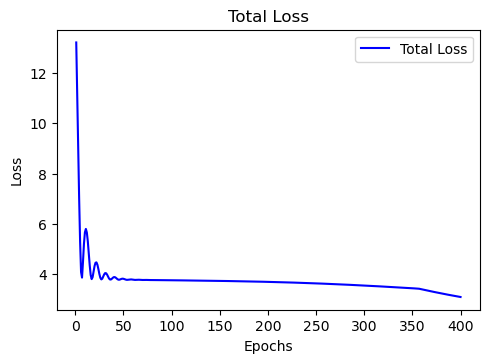

In [13]:
import csv

physics_hyperparam = [0.005]
epochs = [400]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )

results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
        for physics_weight in physics_hyperparam:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCNModel_Hybrid()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=0.005)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 41])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback_Hybrid(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=10,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[early_stopping,loss_tracker])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 41])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
            result_temp = {
                'name':'TΔS with Multi-Loss',
                'y_test': y_test,
                'test_loss': eval,
                'y_pred_test': y_pred_test,
                'MAD': y_difference,
                'all_losses': loss_tracker.total_losses,
                'empirical_losses': loss_tracker.empirical_losses if hasattr(loss_tracker, 'empirical_losses') else None,
                'physical_losses': loss_tracker.physical_losses if hasattr(loss_tracker, 'physical_losses') else None,
                'hyperparameters': {
                                    'physics_weight': physics_weight,
                                    'epochs': epoch,
                                    'initial_learning_rate': 0.005,
                                    'decay_steps': 10000,
                                    'decay_rate': 0.9
                }
            }

            
            # Also append to the all_results list for combined saving later
            results["multi_loss_run"] = result_temp
            all_results.append(result_temp)
        

        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)
            
        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
 

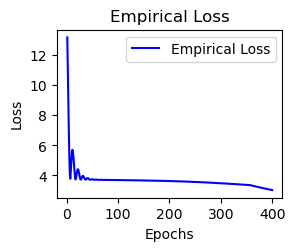

In [14]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

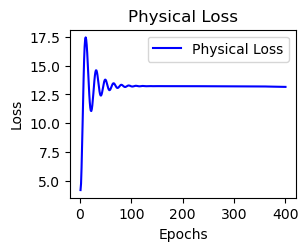

In [16]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

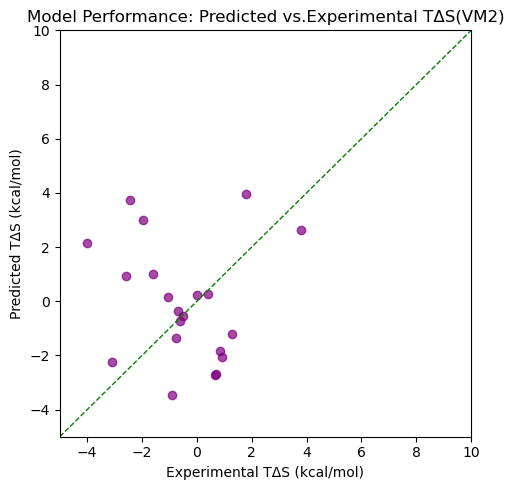

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Model Performance: Predicted vs.Experimental TΔS(VM2)")
plt.scatter(hybrid_y_true, hybrid_y_pred, alpha=0.7, color="purple")
plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)


# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Graphs/Model_Performance_Predicted_vs_Experimental_VM2_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

## VM2 ENTROPY WITHOUT LOSS

In [18]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [19]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [20]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(82, 21, 82, 21)

In [22]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([-.3, -1, 1, 1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
mn.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
mn.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_nohyb = np.array(X_train)
y_train_nohyb = np.array(y_train)

loss_tracker_nohyb = LossComponentsCallback(mn)

early_stop = EarlyStopping(
monitor='loss',           
patience=10,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = mn.fit(X_train_nohyb, y_train_nohyb, epochs = 100, batch_size=len(X_train_nohyb), callbacks=[early_stop,loss_tracker_nohyb])

Epoch 1/100
1/1 [==============================] - 77s 77s/step - loss: 13.1842
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 11.0404
Epoch 3/100
1/1 [==============================] - 1s 853ms/step - loss: 8.9522
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 6.9708
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 5.2201
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 4.0057
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 3.7986
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 4.4293
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 5.1503
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 5.6050
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 5.7401
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 5.5979
Epoch 13/100
1/1 [==============================] - 1s 1s/step - l

In [23]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = mn.evaluate(X_test_nohyb, y_test_nohyb)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))



result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)


1/1 [==============================] - 7s 7s/step - loss: 3.4488
The mean absolute difference between y_tru & y_pred is : 1.7090349837884882


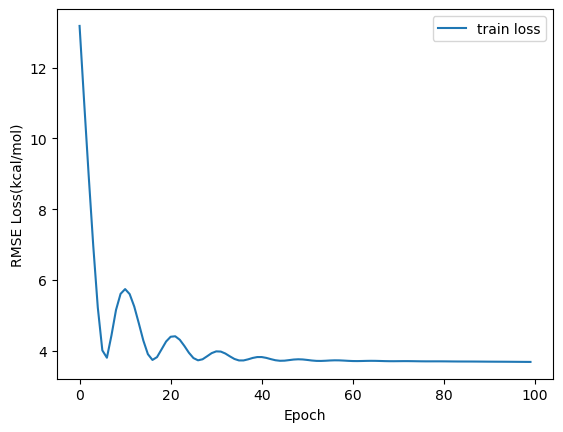

In [24]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE Loss(kcal/mol)')
plt.legend()
plt.show()

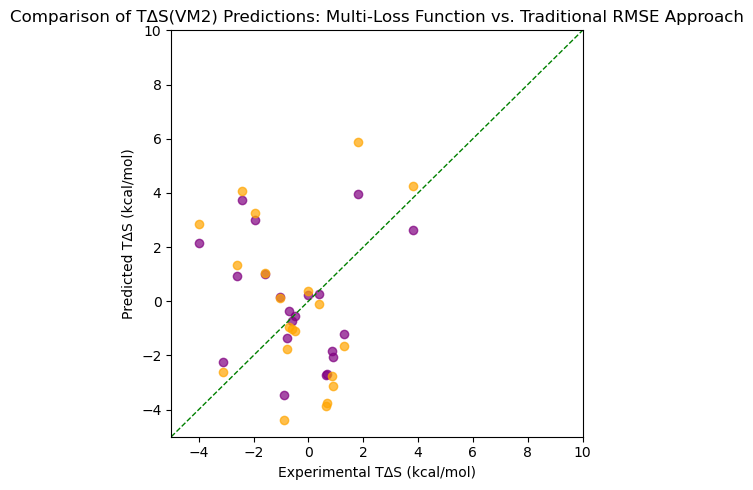

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Comparison of TΔS(VM2) Predictions: Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('VM2Entropy_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## VM2 Entropy with Structural

In [26]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [27]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(82, 21, 82, 21)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([-.3, -1, 1, 1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
       
class LossComponentsCallback_Struct(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms= PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
ms.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
ms.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_struct = np.array(X_train)
y_train_struct = np.array(y_train)

loss_tracker_struct = LossComponentsCallback_Struct(ms)

early_stop = EarlyStopping(
monitor='loss',           
patience=10,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = ms.fit(X_train_struct, y_train_struct, epochs = 200, batch_size=len(X_train_struct), callbacks=[early_stop,loss_tracker_struct])

Epoch 1/200
Inside call
Inside call
1/1 [==============================] - 92s 92s/step - loss: 13.1920
Epoch 2/200
1/1 [==============================] - 19s 19s/step - loss: 11.0549
Epoch 3/200
1/1 [==============================] - 18s 18s/step - loss: 8.9734
Epoch 4/200
1/1 [==============================] - 18s 18s/step - loss: 6.9980
Epoch 5/200
1/1 [==============================] - 18s 18s/step - loss: 5.2501
Epoch 6/200
1/1 [==============================] - 19s 19s/step - loss: 4.0284
Epoch 7/200
1/1 [==============================] - 18s 18s/step - loss: 3.7993
Epoch 8/200
1/1 [==============================] - 18s 18s/step - loss: 4.4146
Epoch 9/200
1/1 [==============================] - 18s 18s/step - loss: 5.1351
Epoch 10/200
1/1 [==============================] - 18s 18s/step - loss: 5.5969
Epoch 11/200
1/1 [==============================] - 18s 18s/step - loss: 5.7415
Epoch 12/200
1/1 [==============================] - 18s 18s/step - loss: 5.6090
Epoch 13/200
1/1 [=====

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [ ]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 41])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
eval_struct = ms.evaluate(X_test_struct, y_test_struct)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))

result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Comparison of TΔS(VM2) Predictions: Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_VM2_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("TΔS(VM2) Comparison between Empirical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multiloss Function")

plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Emp_Struct_Phy_Loss_VM2_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Save individual run results
individual_filename = f'/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/Result_Pickle/VM2_Entropy_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")